<center><h1>Tutorial 2 - Lennard-Jones Fluids </h1>
<br>Mary K. Coe <br>
17 Nov 2021</center>

By the end of this tutorial you will be able to
    - Obtain the equilibrium density profile of a Lennard-Jones fluid in contact with an attractive wall, solute or confined in an attractive slit.
    - Plot this density profile.
    - Determine the numerical consistency of the density profile using two sum rules.

<h3>Introduction</h3>
This tutorial assumes that you already have a general understanding of what classical density functional theory (cDFT) is and how it works, and that <b>you have completed Tutorial 1 - Hard-Sphere Fluids</b>. If you require more background, please consult the following resources.

<a href = "https://doi.org/10.1080/00018737900101365"> R. Evans, Advances in Physics <b>28</b>, 143-200 (1979)</a> - This is a famous review article by Prof Bob Evans which covers most of the maths behind cDFT.

<a href="https://doi.org/10.1088/0953-8984/22/6/063102">R Roth, J. Phys.:Condens. Matter <b>22</b>, 0631102 (2010)</a> - This is a review article by Prof Roland Roth which covers the theory and implementation of Fundamental Measure Theory (FMT). This also describes all functionals available within the package.

J. Hansen and I. R. McDonald, <i>Theory of Simple Liquids</i>, 4th ed (Academic Press, Oxford, 2013). - This book covers the background theory of cDFT for both hard-sphere fluids and Lennard-Jones fluids. It is also an excellent general resouce for theories of liquids.

R. Evans, "Density Functionals in the Theory of Nonuniform Fluids", in <i> Fundamentals of Inhomogeneous Fluids</i> edited by D. Henderson (Marcel Dekker Inc., 1992) pp. 85-175. - This chapter covers cDFT theory and how to implement attractive fluids.

M. K. Coe, "Hydrophobicity across length scales: The role of surface criticality", PhD thesis, (University of Bristol, 2021) - My thesis, available Dec 2021. Chapter 4 as well as Appendices A-C cover the implementation of cDFT within this package in depth.

<b>This package supports Lennard-Jones fluids with an arbitrary truncation.</b> The attraction is implemented using the standard Mean Field Theory treatment of attractions within cDFT - for more information, consult the bottom three resources above. We use the WCA splitting of the Lennard-Jones potential. For further details on the exact implementation, please consult Chapter 4 of my thesis listed above, as well as Appendix B and C.

In addition to a basic knowledge of cDFT, you will need a Python installation with the standard libraries, as well as the <i>NumPy</i>, <i>SciPy</i>, <i>Matplotlib</i> and <i>pyfftw</i> libraries. The latter of these is the python wrapper for the fast fourier transforms library, FFTW. 

<b>Warning</b> - I have noticed that pyfftw does not respect core allocation on nodes on a cluster. For example, if you request one core on one node, pyfftw appears to automatically use all cores within the node. If using the package on a cluster, it is therefore recommended you run it using mpiexec or equivalent, to force it to use only the requested number of cores.

With this in mind, we begin the tutorial by importing necessary libraries.

In [1]:
# Import necessary libraries for tutorial
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors

import cDFT.minimisation as minimise
import cDFT.measures as measure

<h3>Planar Wall</h3>
Much like hard-sphere fluids, Lennard-Jones fluids are declared using the <i>minimise.DFT</i> object. The main difference is that the fluid type is now <i>TLJ</i>, which stands for truncated Lennard-Jones, and that a cut-off radius for the interaction (<i>cut_off</i>) may be suppled. The default for this is <i>2.5$\sigma$</i>, where $\sigma$ is the diameter of a fluid particle. Whilst the package only supports truncated Lennard-Jones fluids, these may have any truncation, hence a long-ranged Lennard-Jones fluid can be emulated by choosing a very large cut-off, for example, <i>cut_off = 200$\sigma$</i>. 

<b>A word of warning - for efficiency, this package uses fast fourier transforms. This means it also uses zero padding. Therefore, the longer the cut-off, the more memory required. If studying large cut-offs, it may be best to use this package on a machine with high memory.</b>

In [2]:
LJ = minimise.DFT(bulk_density = 0.59803, # Density at a slight oversaturation
                  temperature = 1.02257,  # Equivalent to 0.775Tc
                  fluid_type = 'TLJ',     # Truncated Lennard-ones fluid
                  cut_off = 2.5           # Cut-off radius of interaction
                 )

LJ.information()

Fluid type: truncated Lennard-Jones fluid with cut-off radius of interaction 2.5 * diameter of a fluid particle
Temperature: 1.02257
Density of bulk fluid: 0.59803
Functional: Rosenfeld
Length of grid: 50.0 * diameter of a fluid particle
Distance between grid points: 0.001 * diameter of a fluid particle


For a planar surface/wall, four wall types are available. The first is the hard wall (<i>HW</i>) as demonstrated in Tutorial 1. The remaining three all take the form of a hard surface/wall, with a <b>long-ranged</b> Lennard-Jones attraction. This attraction fills the entire system. The difference between each of these is the definition of the Lennard-Jones attraction. 

The Lennard-Jones (<i>wall_type = LJ</i>) wall type has an interaction potential of
\begin{equation}
    V_{ext,LJ}(z) = \begin{cases}
        \infty & z<0 \\
        \varepsilon_{sf}\left[\frac{2}{15}\left(\frac{\sigma_s}{z}\right)^9 - \left(\frac{\sigma_s}{z}\right)^3\right] & z>0
    \end{cases}
\end{equation}
where $\sigma_s$ is the diameter of a wall particle, $\varepsilon_{sf}$ is a measure of the wall-fluid attraction strength and $z$ is the perpendicular distance from the wall. 

The shifted Lennard-Jones (<i>wall_type = SLJ</i>) wall type has an interaction potential of 
\begin{equation}
    V_{ext,SLJ}(z) = \begin{cases}
        \infty & z<0 \\
        \varepsilon_{sf}\left[\frac{2}{15}\left(\frac{\sigma_s}{z+z_{min}}\right)^9 - \left(\frac{\sigma_s}{z+z_{min}}\right)^3\right] & z>0
    \end{cases}
\end{equation}
where $z_{min}=(2/5)^{1/6}\sigma_s$ is the minimum of the integrated potential (see my thesis for more information) and all other symbols take their meanings as above. This potential is identical to the <i>LJ</i> potential with the minimum shifted such that it occurs at the surface of the wall.

The final Lennard-Jones wall type (<i>wall_type = WCALJ</i>) uses the WCA splitting used for implementing the <i>TLJ</i> fluid. It takes the form
\begin{equation}
    V_{ext,WCALJ}(z) = \begin{cases}
        \infty & z<0 \\
        \varepsilon_{sf}\left[-\frac{r_{min,s}^3}{\sigma_s^3} - \frac{z^3}{2\sigma_s^3} + \frac{3r_{min,s}^2z}{2\sigma_s^3} + \frac{4\sigma_s^9}{3r_{min,s}^9} - \frac{4\sigma_s^3}{r_{min,s}^3} - \frac{6\sigma_s^9z}{5r_{min,s}^10} + \frac{3\sigma_s^3z}{r_{min,s}^4} \right] & 0<z<r_{min,s} \\
        \varepsilon_{sf}\left[\frac{2}{15}\left(\frac{\sigma_s}{z+z_{min}}\right)^9 - \left(\frac{\sigma_s}{z+z_{min}}\right)^3\right] & z>r_{min,s}
    \end{cases}
\end{equation}
where $r_{min,s} = 2^{1/6}\sigma_s$ is the minimum of the wall particle - fluid particle interaction potential and all other symbols are as above. 

Below we compare these for the default value, $\varepsilon_{sf}$=10. <b>Note - The code below will take approximately 4 minutes to run.</b>

1000 complete. Deviation: 3.501019905094438e-06

2000 complete. Deviation: 1.325113404004874e-07

3000 complete. Deviation: 5.181984841229337e-09

4000 complete. Deviation: 2.099594942350791e-10

5000 complete. Deviation: 5.035361017036166e-12

Convergence achieved in 5712 attempts.
Convergence achieved in 122 attempts.
Convergence achieved in 104 attempts.
Convergence achieved in 114 attempts.


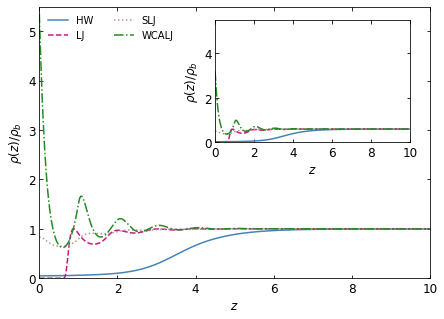

In [3]:
def plot_all_planar_wall_types(planar_objects):
    """
    Plots the equilibrium density profiles for up to 4 
    planar objects.
    
    Parameters
    ----------
    planar_objects: list(minimise.planar)
        List of planar objects which have had the minimise method called.
        
    Returns
    -------
    None.
    """
    
    colours = ['steelblue', 'mediumvioletred', 'rosybrown', 'forestgreen']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot']
    
    fig = plt.figure(figsize=(7,5))
    ax_main = fig.add_subplot(111)

    
    max_density = []
    for planar, colour, line_style in zip(planar_objects.values(),colours, line_styles):
        L = int(10./planar.DFT.dr)
        z, density = planar.equilibrium_profile()
        density /= planar.DFT.bulk_density
        ax_main.plot(z[:L], density[:L], color = colour, ls = line_style, label = planar.wall_type)
        
    max_density.append(np.amax(density))
    
    maxy = 0.5*(np.ceil(max(max_density)/0.5))
    
    if maxy>1.5:
        ax_inset = ax_main.inset_axes([0.45,0.5,0.5,0.45], 
                                     transform = ax_main.transAxes)
    else:
        ax_inset = ax_main.inset_axes([0.475,0.15,0.5,0.4], 
                                     transform = ax_main.transAxes)
    for planar, colour, line_style in zip(planar_objects.values(),colours, line_styles):
        z, density = planar.equilibrium_profile()
        ax_inset.plot(z, density,color = colour, ls = line_style)
        
    ax_main.set_xlim(0.0,10.0)
    ax_main.set_ylim(0.0,maxy)
    ax_inset.set_xlim(0.0,10.0)
    ax_inset.set_ylim(0.0,maxy)
    ax_main.tick_params(direction = 'in', top = True, right = True, labelsize = 12)
    ax_inset.tick_params(direction = 'in', top = True, right = True, labelsize = 12)
    ax_main.set_xlabel(r'$z$', fontsize = 12)
    ax_main.set_ylabel(r'$\rho(z)/\rho_b$', fontsize = 12)
    ax_inset.set_xlabel(r'$z$', fontsize = 12)
    ax_inset.set_ylabel(r'$\rho(z)/\rho_b$', fontsize = 12)
    
    ax_main.legend(frameon = False, loc = 'upper left', ncol = 2)
        

def find_planar_LJ_density_profile(LJ, wall_type, epsilon_wall = 1.0):
    """
    Defines a DFT in the planar wall geometry and calls
    the minimise method.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find the equilibrium density profile
        of.
    wall_type: string
        Type of wall-fluid interaction. Options are
        hard (HW), Lennard-Jones (LJ), shifted 
        Lennard-Jones (SLJ) or WCA Lennard-Jones 
        (WCALJ) wall.
    epsilon_wall: float, optional
        Strength of wall-fluid interactions.
    
    Returns
    -------
    minimise.planar object:
        DFT system with equilibrium density profile.
    """
    
    planar = minimise.planar(LJ, wall_type = wall_type, epsilon_wall = epsilon_wall)
    planar.minimise()
    
    return planar

def demonstrate_all_planar_wall_types(LJ):
    """
    Finds the equilibrium density profiles for a 
    fluid subjected to each of the different 
    available wall-fluid interaction potentials
    in the planar wall geometry.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find equilibrium density profile of.
        
    Returns
    -------
    wall_examples: List(minimise.planar objects)
        List of planar objects with equilibrium density 
        profile.
    """
    
    wall_types = ['HW', 'LJ', 'SLJ', 'WCALJ']
    wall_examples = {}
    for wall_type in wall_types:
        wall_examples[wall_type] = find_planar_LJ_density_profile(LJ, wall_type)
    
    return wall_examples

wall_examples = demonstrate_all_planar_wall_types(LJ)
plot_all_planar_wall_types(wall_examples)

The plot above shows how the fluid responds to different wall types. For the hard wall (solid blue), a vapour-like film appears, which is indicative of drying (in fact if this fluid were at coexistence, this system would undergo the critical drying transition - see my thesis for more details). In contrast, the large attraction between the various Lennard-Jones walls and the fluid mean there is little evidence of even density depletion. The WCALJ wall (dash-dot green) shows a large density at the surface of the wall and large osciliations which indicate liquid packing effects near to the wall. The LJ wall (dashed pink) shows a low a low density near the wall, where the interaction potential tends to infinity, with oscillations further from the wall. The SLJ wall (dotted brown) shows weaker oscillations, and a density near the wall which is similar to the bulk density.

This plot highlights the differences between the LJ potentials. We can further understand the differences by comparing the results of the sum rules.

In [4]:
full_names = {'HW': 'Hard', 'WCALJ': 'WCA Lennard-Jones', 'LJ': 'Lennard-Jones', 'SLJ': 'Shifted Lennard-Jones'}

def print_sum_rule_results(wall_examples):
    """
    Prints the adsorption and contact sum rule results for all systems
    suppled.
    
    Parameters
    ----------
    wall_examples: list(minimise.planar/minimise.spherical/minimise.slit objects)
        List containing all DFT systems.
    
    Returns
    -------
    None.
    """
        
    for wall_name, wall in zip(wall_examples.keys(), wall_examples.values()):
        try:
            print(f'{full_names[wall_name]} Wall')
            wall.adsorption_sum_rule()
            wall.contact_sum_rule()
        except:
            print(f'Wall type not found!')
            
print_sum_rule_results(wall_examples)

Hard Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -2.1037599040
-dgamma/dmu = -2.1035909219
Relative error = 0.0000803238
--------------------------------------------

--------------------------------------------
Contact Sum Rule Results:
pressure = 0.0296786993
kbT*rho(0) = 0.0296786990
Relative Error = 0.0000000080
--------------------------------------------

Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.6012770915
-dgamma/dmu = -0.6012786423
Relative error = 0.0000025793
--------------------------------------------

----------------------------------------------------
Pressure = 0.0296786993 Sum Rule = 0.0296834834
Relative Error = 0.0001611966
----------------------------------------------------

Shifted Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.2508147195
-dgamma/dmu = -0.2503666983
Relative error = 0.0017862637

Whilst the errors in the sum rules (which indicate numerical accuracy - see Tutorial 1) for most walls are fairly low, for the WCALJ wall we see a high contact sum rule error. This is due to the large density at the surface - all systems with vary large densities at the surface give a large error here. However, this indicates the WCALJ wall is not very numerically consistent for such a large $\varepsilon_{sf}$. In contrast, if $\varepsilon_{sf}$=0.1, we would find that the contact sum rule breaks down for the LJ wall. For the LJ wall, it is also important to consider the diverging potential at the surface of the wall as finite representation of numbers within a computer means that this can lead to a poorly defined surface of the wall. In general, the most numerically consistant and well defined is the SLJ wall. 

<b>Note</b> - Your choice of epsilon_wall matters when using LJ, SLJ or WCALJ wall types. If it is too large (or in the case of the LJ wall, too small), the minimise process will fail. This normally presents as a convergence in only a couple of attempts and very large sum rule errors, particularly contact sum rule errors. In general, the safe ranges for each wall are: LJ: (0.15 -> 1.5), SLJ: (0->2.14), WCALJ: (0.0->1.2).

Despite this there are regions of $\varepsilon_{sf}$ for which all types of LJ wall are fairly numerically consistent. Below is an example of this.

Convergence achieved in 365 attempts.
Convergence achieved in 562 attempts.
Convergence achieved in 92 attempts.


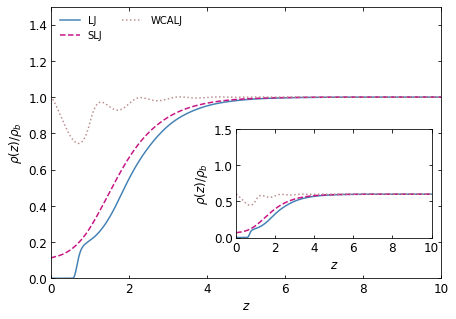

In [5]:
def compare_LJ_wall_types(LJ, epsilon_wall):
    """
    Compares each of the different Lennard-Jones
    wall types available within the planar wall
    geometry for a given wall-fluid attraction
    strength.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find the equilibrium profiles of
    epsilon_wall: float
        Strength of the wall-fluid attraction
    
    Returns
    -------
    wall_examples: List(minimise.planar objects)
        List of all planar wall systems with 
        equilibrium density profiles found.
    """

    wall_types = ['LJ', 'SLJ', 'WCALJ']
    wall_examples = {}
    for wall_type in wall_types:
        wall_examples[wall_type] = find_planar_LJ_density_profile(LJ, wall_type, epsilon_wall = epsilon_wall)
    
    return wall_examples

LJ_wall_examples = compare_LJ_wall_types(LJ,0.3)
plot_all_planar_wall_types(LJ_wall_examples)

In [6]:
print_sum_rule_results(LJ_wall_examples)

Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -1.2035605976
-dgamma/dmu = -1.2035388076
Relative error = 0.0000181046
--------------------------------------------

----------------------------------------------------
Pressure = 0.0296786993 Sum Rule = 0.0296801345
Relative Error = 0.0000483595
----------------------------------------------------

Shifted Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.9912120747
-dgamma/dmu = -0.9906005658
Relative error = 0.0006169304
--------------------------------------------

----------------------------------------------------
Pressure = 0.0296786993 Sum Rule = 0.0296801189
Relative Error = 0.0000478333
----------------------------------------------------

WCA Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.1425213891
-dgamma/dmu = -0.1421571503
Relative error = 0.002555678

<h3>Spherical Wall (Solute)</h3>
Spherical walls or solutes within the package have much the options as the planar wall with one exception - WCALJ wall types are not available. Below is a demonstration of the wall types available for a solute of radius $R_s=$100$\sigma$.

Convergence achieved in 792 attempts.
Convergence achieved in 122 attempts.
Convergence achieved in 104 attempts.


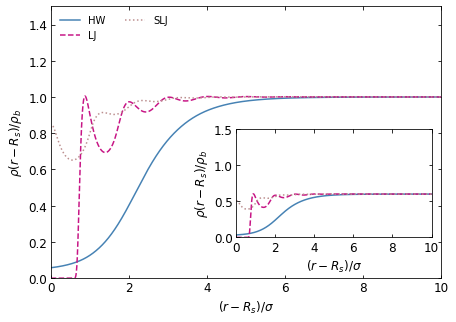

In [7]:
def plot_all_spherical_wall_types(solutes):
    """
    Plots the equilibrium density profiles for up to 3 
    spherical objects.
    
    Parameters
    ----------
    solutes: list(minimise.spherical)
        List of spherical objects which have had the minimise method called.
        
    Returns
    -------
    None.
    """
    
    colours = ['steelblue', 'mediumvioletred', 'rosybrown']
    line_styles = ['solid', 'dashed', 'dotted']
    
    fig = plt.figure(figsize=(7,5))
    ax_main = fig.add_subplot(111)

    max_density = []
    for solute, colour, line_style in zip(solutes.values(),colours, line_styles):
        L = int(10./solute.DFT.dr)
        r, density = solute.equilibrium_profile()
        density /= solute.DFT.bulk_density
        ax_main.plot(r[:L]-solute.Rs, density[:L], color = colour, ls = line_style, label = solute.wall_type)
        
    max_density.append(np.amax(density))
    
    maxy = 0.5*(np.ceil(max(max_density)/0.5))
    
    if maxy>1.5:
        ax_inset = ax_main.inset_axes([0.45,0.5,0.5,0.45], 
                                     transform = ax_main.transAxes)
    else:
        ax_inset = ax_main.inset_axes([0.475,0.15,0.5,0.4], 
                                     transform = ax_main.transAxes)
    for solute, colour, line_style in zip(solutes.values(),colours, line_styles):
        r, density = solute.equilibrium_profile()
        ax_inset.plot(r-solute.Rs, density, color = colour, ls = line_style)
        
    ax_main.set_xlim(0.0,10.0)
    ax_main.set_ylim(0.0,maxy)
    ax_inset.set_xlim(0.0,10.0)
    ax_inset.set_ylim(0.0,maxy)
    ax_main.tick_params(direction = 'in', top = True, right = True, labelsize = 12)
    ax_inset.tick_params(direction = 'in', top = True, right = True, labelsize = 12)
    ax_main.set_xlabel(r'$(r-R_s)/\sigma$', fontsize = 12)
    ax_main.set_ylabel(r'$\rho(r-R_s)/\rho_b$', fontsize = 12)
    ax_inset.set_xlabel(r'$(r-R_s)/\sigma$', fontsize = 12)
    ax_inset.set_ylabel(r'$\rho(r-R_s)/\rho_b$', fontsize = 12)
    
    ax_main.legend(frameon = False, loc = 'upper left', ncol = 2)
        

def find_spherical_LJ_density_profile(LJ, wall_type, Rs=100.0, epsilon_wall = 1.0):
    """
    Defines a DFT in the spherical wall geometry and calls
    the minimise method.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find the equilibrium density profile
        of.
    wall_type: string
        Type of wall-fluid interaction. Options are
        hard (HW), Lennard-Jones (LJ), shifted 
        Lennard-Jones (SLJ) wall.
    Rs: float
        Radius of the spherical wall in units of 
        fluid particle diameters.
    epsilon_wall: float, optional
        Strength of wall-fluid interactions.
    
    Returns
    -------
    minimise.spherical object:
        DFT system with equilibrium density profile.
    """
    
    solute = minimise.spherical(LJ, Rs = Rs, wall_type = wall_type, epsilon_wall = epsilon_wall)
    solute.minimise()
    
    return solute

def demonstrate_all_spherical_wall_types(LJ, Rs = 100.0):
    """
    Finds the equilibrium density profiles for a 
    fluid subjected to each of the different 
    available wall-fluid interaction potentials
    in the spherical wall geometry.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find equilibrium density profile of.
    Rs: float, optional
        Radius of the spherical wall (solute) in units
        of fluid particle diameters.
        
    Returns
    -------
    wall_examples: List(minimise.spherical objects)
        List of spherical objects with equilibrium density 
        profile.
    """
    
    wall_types = ['HW', 'LJ', 'SLJ']
    wall_examples = {}
    for wall_type in wall_types:
        wall_examples[wall_type] = find_spherical_LJ_density_profile(LJ, wall_type, Rs)
    
    return wall_examples

wall_examples = demonstrate_all_spherical_wall_types(LJ)
plot_all_spherical_wall_types(wall_examples)

Just as with the planar wall, the hard solute exhibits a vapour-like layer near its surface. The Lennard-Jones solute-fluid interaction exhibits oscillations indicative of liquid packing effects and a low density region where the interaction potential diverges. The shifted Lennard-Jones solute exhibits a small density depletion, followed by oscillations.

Evaluating the sum rules shows these systems to be numerically accurate.

In [8]:
print_sum_rule_results(wall_examples)

Hard Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -1.4073697700
-dgamma/dmu = -1.4076600509
Relative error = 0.0002062578
--------------------------------------------

----------------------------------------------------
Contact Sum Rule A:
beta*d(omega)/(dRb) = 4325.5105446962
4piRs^2rho(Rs) = 4325.3862032893
Relative Error = 0.0000287469

Contact Sum Rule B:
kbTrho(Rs) = 0.0351971966
p + 2gamma/Rs + dgamma/dRs = 0.0351972150
Relative Error = 0.0000005240
-----------------------------------------------------

Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.6064105791
-dgamma/dmu = -0.6064336366
Relative error = 0.0000380228
--------------------------------------------

----------------------------------------------------
Potential Side = 0.0311597863 Sum Rule = 0.0311618152
Relative Error = 0.0000651137
----------------------------------------------------

Shifted Lennard-Jones Wall

The largest error above should be to 3 decimal places. Finally, we demonstrate the same wall-fluid interactions, but with a smaller solute of $R_s$=10$\sigma$.

Convergence achieved in 193 attempts.
Convergence achieved in 122 attempts.
Convergence achieved in 96 attempts.
Hard Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.7780608642
-dgamma/dmu = -0.7797391197
Relative error = 0.0021569720
--------------------------------------------

----------------------------------------------------
Contact Sum Rule A:
beta*d(omega)/(dRb) = 116.3534307058
4piRs^2rho(Rs) = 116.3300196286
Relative Error = 0.0002012471

Contact Sum Rule B:
kbTrho(Rs) = 0.0946618493
p + 2gamma/Rs + dgamma/dRs = 0.0946624958
Relative Error = 0.0000068292
-----------------------------------------------------

Lennard-Jones Wall

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.6561510240
-dgamma/dmu = -0.6563724568
Relative error = 0.0003374722
--------------------------------------------

----------------------------------------------------
Potential Side = 0.0483845657 Sum Rule = 0.0483915415

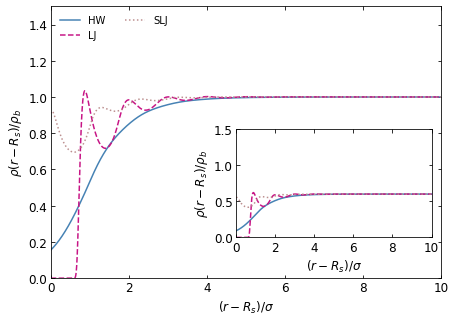

In [9]:
wall_examples = demonstrate_all_spherical_wall_types(LJ, Rs=10.0)
plot_all_spherical_wall_types(wall_examples)
print_sum_rule_results(wall_examples)

<h3>Slit</h3>
The slit geometry only supports the shifted Lennard-Jones wall type, however each wall of the slit can have a different $\varepsilon_{sf}$. We demonstrate this below, first for a slit with similar walls but different $\varepsilon_{sf}$ then for a slit with one hard wall of one shifted Lennard-Jones wall.

Fluid type: truncated Lennard-Jones fluid with cut-off radius of interaction 2.5 * diameter of a fluid particle
Temperature: 1.02257
Density of bulk fluid: 0.59803
Functional: Rosenfeld
Length of grid: 25.0 * diameter of a fluid particle
Distance between grid points: 0.001 * diameter of a fluid particle
Convergence achieved in 253 attempts.

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -0.6934391875
-dgamma/dmu = -0.6924462261
Relative error = 0.0014319372
--------------------------------------------

----------------------------------------------------
Left Wall = 0.00007537109922
Right Wall = 0.00007536936790
Relative Error = 0.00002297050435
------------------------------------------------------
Solvation Force = 0.00007535624990
Relative Errors: LHS: 0.0001970549
Relative Errors: RHS: 0.0001740799
----------------------------------------------------



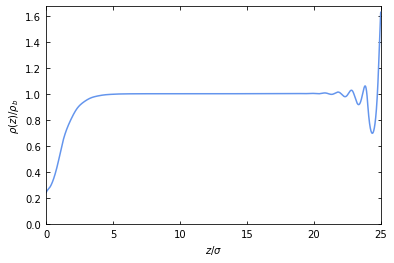

In [10]:
def demonstrate_similar_wall_slit(LJ, wall_type, left_epsilon=1.0, right_epsilon=1.0):
    """
    Finds the equilibrium density profiles for a 
    fluid confined within a slit geometry. Each
    wall of the slit exerts the same form of 
    potential on the fluid however may be of 
    different strength. Each sum rule is then 
    evaluated with results printed. The final
    density profile is plotted.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find equilibrium density profile of.
    wall_type: string
        Type of wall-fluid potential. Options are 
        hard (HW) or shifted Lennard-Jones (SLJ) wall.
    left_epsilon: float, optional
        Strength of wall-fluid attraction exerted by 
        left wall of slit.
    right_epsilon: float, optional
        Strength of wall-fluid attraction exerted by 
        right wall of slit.
        
    Returns
    -------
    None
    """
    
    slit = minimise.slit(LJ,
                         left_wall_type = wall_type, right_wall_type = wall_type,
                         left_epsilon_wall = left_epsilon, right_epsilon_wall=right_epsilon)
    slit.minimise()
    slit.adsorption_sum_rule()
    slit.contact_sum_rule()
    slit.plot()

shorter_LJ = minimise.DFT(bulk_density = 0.59803, # Density at a slight oversaturation
                          temperature = 1.02257,  # Equivalent to 0.775Tc
                          L = 25.0,               # Width of slit
                          fluid_type = 'TLJ',     # Truncated Lennard-ones fluid
                          cut_off = 2.5           # Cut-off radius of interaction
                         )

shorter_LJ.information()
demonstrate_similar_wall_slit(shorter_LJ, wall_type = 'SLJ', left_epsilon=0.5, right_epsilon=1.5)

1000 complete. Deviation: 2.960482706315659e-06

2000 complete. Deviation: 7.773995042148485e-08

3000 complete. Deviation: 2.1895892876599987e-09

4000 complete. Deviation: 6.559325305133257e-11

5000 complete. Deviation: 1.3643530749618549e-12

Convergence achieved in 5132 attempts.

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = -2.3276867673
-dgamma/dmu = -2.3271265842
Relative error = 0.0002406609
--------------------------------------------

----------------------------------------------------
Left Wall = 0.00005336148642
Right Wall = 0.00005335913486
Relative Error = 0.00000000235156
------------------------------------------------------


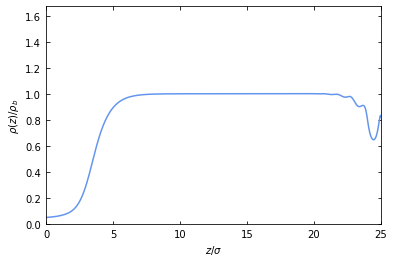

In [11]:
def demonstrate_different_wall_slit(LJ, left_wall_type, right_wall_type, left_epsilon=1.0, right_epsilon=1.0):
    """
    Finds the equilibrium density profiles for a 
    fluid confined within a slit geometry. Each
    wall of the slit may exert a different form  
    of potential on the fluid. Each sum rule is then 
    evaluated with results printed. The final
    density profile is plotted.
    
    Parameters
    ----------
    LJ: minimise.DFT object
        Fluid to find equilibrium density profile of.
    left_wall_type: string
        Type of wall-fluid potential for left wall of slit.
        Options are hard (HW) or shifted Lennard-Jones (SLJ)
        wall.
    right_wall_type: string
        Type of wall-fluid potential for right wall of slit. 
        Options are hard (HW) or shifted Lennard-Jones (SLJ)
        wall.
    left_epsilon: float, optional
        Strength of wall-fluid attraction exerted by 
        left wall of slit.
    right_epsilon: float, optional
        Strength of wall-fluid attraction exerted by 
        right wall of slit.
        
    Returns
    -------
    None
    """
    slit = minimise.slit(LJ,
                         left_wall_type = left_wall_type, right_wall_type = right_wall_type,
                         left_epsilon_wall = left_epsilon, right_epsilon_wall=right_epsilon)
    slit.minimise()
    slit.adsorption_sum_rule()
    slit.contact_sum_rule()
    slit.plot()
    
demonstrate_different_wall_slit(shorter_LJ, 'HW', 'SLJ')

In both cases, the sum rules are obeyed well. 

<h3>Up Next</h3>
Within this tutorial, the abilities of the package with respect to Lennard-Jones fluids and Lennard-Jones walls/solutes has been outlined. In the next (and final) tutorial, we will look at some of the different measures the package supports.